# Import Libraries

In [141]:
#import all the required libraries
import numpy as np
import pandas as pd
import pickle
from statistics import mode
import nltk
from nltk import word_tokenize
from nltk.stem import LancasterStemmer
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from tensorflow.keras.models import Model
from tensorflow.keras import models
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input,LSTM,Embedding,Dense,Concatenate,Attention
from sklearn.model_selection import train_test_split
from bs4 import BeautifulSoup

import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

from tensorflow.keras.callbacks import EarlyStopping

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Parse the Data

We’ll take a sample of 100,000 reviews to reduce the training time of our model.

In [142]:
#read the dataset file for text Summarizer
df=pd.read_csv("/kaggle/input/news-summary/news_summary.csv",encoding='iso-8859-1')
# df = pd.read_csv("/content/news_summary.csv")
#drop the duplicate and na values from the records
df.drop_duplicates(subset=['text'],inplace=True)
df.dropna(axis=0,inplace=True) #dropping na
df = df.drop(['author','date','read_more','ctext'], 1)
df = df.reset_index(drop=True)
input_data = df.loc[:,'text']
target_data = df.loc[:,'headlines']
target_data.replace('', np.nan, inplace=True)

In [143]:
df

,headlines,text
0,Daman & Diu revokes mandatory Rakshabandhan in offices order,The Administration of Union Territory Daman and Diu has revoked its order that made it compulsory for women to tie rakhis to their male colleagues on the occasion of Rakshabandhan on August 7. The...
1,Malaika slams user who trolled her for 'divorcing rich man',"Malaika Arora slammed an Instagram user who trolled her for ""divorcing a rich man"" and ""having fun with the alimony"". ""Her life now is all about wearing short clothes, going to gym or salon, enjoy..."
2,'Virgin' now corrected to 'Unmarried' in IGIMS' form,"The Indira Gandhi Institute of Medical Sciences (IGIMS) in Patna on Thursday made corrections in its Marital Declaration Form by changing 'Virgin' option to 'Unmarried'. Earlier, Bihar Health Mini..."
3,Aaj aapne pakad liya: LeT man Dujana before being killed,"Lashkar-e-Taiba's Kashmir commander Abu Dujana, who was killed by security forces, said ""Kabhi hum aage, kabhi aap, aaj aapne pakad liya, mubarak ho aapko (Today you caught me. Congratulations)"" a..."
4,Hotel staff to get training to spot signs of sex trafficking,"Hotels in Maharashtra will train their staff to spot signs of sex trafficking, including frequent requests for bed linen changes and 'Do not disturb' signs left on room doors for days. A mobile ph..."
...,...,...
4391,Rasna seeking ?250 cr revenue from snack category: Chairman,"Fruit juice concentrate maker Rasna is eyeing a revenue of ?250 crore in the next three years from the snack category, Chairman Piruz Khambatta said. Rasna, which has presence in the sweet snack c..."
4392,Sachin attends Rajya Sabha after questions on attendance,Former Indian cricketer Sachin Tendulkar attended the Rajya Sabha a couple of days after Samajwadi Party MP Naresh Agrawal asked him and actress Rekha to resign from their positions due to their l...
4393,Shouldn't rob their childhood: Aamir on kids reality shows,"Aamir Khan, while talking about reality shows on television that feature kids, said that these shows shouldn't be so aggressive that they rob children of their childhood. ""I haven't seen those rea..."
4394,"Asha Bhosle gets ?53,000 power bill for unused bungalow","The Maharashtra government has initiated an inquiry after 83-year-old singer Asha Bhosle complained of receiving an electricity bill of over ?53,000 for her unused bungalow in Lonawala. The state ..."


In [144]:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4396 entries, 0 to 4395
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   headlines  4396 non-null   object
 1   text       4396 non-null   object
dtypes: object(2)
memory usage: 68.8+ KB


In [145]:
df.isnull().sum()

headlines    0
text         0
dtype: int64

In [146]:
df['headlines'][:10]

0    Daman & Diu revokes mandatory Rakshabandhan in offices order
1    Malaika slams user who trolled her for 'divorcing rich man' 
2            'Virgin' now corrected to 'Unmarried' in IGIMS' form
3        Aaj aapne pakad liya: LeT man Dujana before being killed
4    Hotel staff to get training to spot signs of sex trafficking
5    Man found dead at Delhi police station, kin allege foul play
6     Delhi HC reduces aid for 'negligent' accident victim by 45%
7    60-yr-old lynched over rumours she was cutting people's hair
8     Chopper flying critically low led to 2015 Bombay High crash
9                Congress opens 'State Bank of Tomato' in Lucknow
Name: headlines, dtype: object

In [147]:
df['text'][:10]

0    The Administration of Union Territory Daman and Diu has revoked its order that made it compulsory for women to tie rakhis to their male colleagues on the occasion of Rakshabandhan on August 7. The...
1    Malaika Arora slammed an Instagram user who trolled her for "divorcing a rich man" and "having fun with the alimony". "Her life now is all about wearing short clothes, going to gym or salon, enjoy...
2    The Indira Gandhi Institute of Medical Sciences (IGIMS) in Patna on Thursday made corrections in its Marital Declaration Form by changing 'Virgin' option to 'Unmarried'. Earlier, Bihar Health Mini...
3    Lashkar-e-Taiba's Kashmir commander Abu Dujana, who was killed by security forces, said "Kabhi hum aage, kabhi aap, aaj aapne pakad liya, mubarak ho aapko (Today you caught me. Congratulations)" a...
4    Hotels in Maharashtra will train their staff to spot signs of sex trafficking, including frequent requests for bed linen changes and 'Do not disturb' signs left on room doors 

In [148]:
df['text'][0]

'The Administration of Union Territory Daman and Diu has revoked its order that made it compulsory for women to tie rakhis to their male colleagues on the occasion of Rakshabandhan on August 7. The administration was forced to withdraw the decision within 24 hours of issuing the circular after it received flak from employees and was slammed on social media.'

# Preprocessing

Performing basic preprocessing steps is very important before we get to the model building part. Using messy and uncleaned text data is a potentially disastrous move. So in this step, we will drop all the unwanted symbols, characters, etc. from the text that do not affect the objective of our problem.

Here is the dictionary that we will use for expanding the contractions:

In [149]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

We can use the contraction using two method, one we can use the above dictionary or we can keep the contraction file as a data set and import it. 

In [150]:
input_texts=[]  # Text column
target_texts=[] # summary column
input_words=[]
target_words=[]
# contractions=pickle.load(open("../input/contraction/contractions.pkl","rb"))['contractions']
contractions = contraction_mapping

#initialize stop words and LancasterStemmer
stop_words=set(stopwords.words('english'))
stemm=LancasterStemmer()

# Data Cleaning

In [151]:
def clean(texts,src):
  texts = BeautifulSoup(texts, "lxml").text   #remove the html tags
  words=word_tokenize(texts.lower())  #tokenize the text into words 
  #filter words which contains \ 
  #integers or their length is less than or equal to 3
  words= list(filter(lambda w:(w.isalpha() and len(w)>=3),words))
  #contraction file to expand shortened words
  words= [contractions[w] if w in contractions else w for w in words ]

  #stem the words to their root word and filter stop words
  if src=="inputs":
    words= [stemm.stem(w) for w in words if w not in stop_words]
  else:
    words= [w for w in words if w not in stop_words]
  return words

In [152]:
#pass the input records and target records
for in_txt,tr_txt in zip(input_data,target_data):
  in_words= clean(in_txt,"inputs")
  input_texts+= [' '.join(in_words)]
  input_words+= in_words
  #add 'sos' at start and 'eos' at end of text
  tr_words= clean("sos "+tr_txt+" eos","target")
  target_texts+= [' '.join(tr_words)]
  target_words+= tr_words

In [153]:
from scipy import stats as s

In [154]:
#store only unique words from input and target list of words
input_words = sorted(list(set(input_words)))
target_words = sorted(list(set(target_words)))
num_in_words = len(input_words) #total number of input words
num_tr_words = len(target_words) #total number of target words
#get the length of the input and target texts which appears most often  
max_in_len = mode([len(i) for i in input_texts])
max_tr_len = (int(s.mode([len(i) for i in target_texts])[0]))
 
print("number of input words : ",num_in_words)
print("number of target words : ",num_tr_words)
print("maximum input length : ",max_in_len)
print("maximum target length : ",max_tr_len)

number of input words :  10784
number of target words :  7792
maximum input length :  190
maximum target length :  53


# Split it

In [155]:
#split the input and target text into 80:20 ratio or testing size of 20%.
x_train,x_test,y_train,y_test=train_test_split(input_texts,target_texts,test_size=0.2,random_state=0) 

In [156]:
X_test=x_train
Y_test=y_train

In [157]:
#train the tokenizer with all the words
in_tokenizer = Tokenizer()
in_tokenizer.fit_on_texts(x_train)
tr_tokenizer = Tokenizer()
tr_tokenizer.fit_on_texts(y_train)
 
#convert text into sequence of integers
#where the integer will be the index of that word
x_train= in_tokenizer.texts_to_sequences(x_train) 
y_train= tr_tokenizer.texts_to_sequences(y_train)

In [158]:
#pad array of 0's if the length is less than the maximum length 
en_in_data= pad_sequences(x_train,  maxlen=max_in_len, padding='post') 
dec_data= pad_sequences(y_train,  maxlen=max_tr_len, padding='post')
 
#decoder input data will not include the last word 
#i.e. 'eos' in decoder input data
dec_in_data = dec_data[:,:-1]
#decoder target data will be one time step ahead as it will not include
# the first word i.e 'sos'
dec_tr_data = dec_data.reshape(len(dec_data),max_tr_len,1)[:,1:]

In [159]:
en_in_data

array([[  77, 2847, 1320, ...,    0,    0,    0],
       [ 528,   33, 1200, ...,    0,    0,    0],
       [ 325,  210,   16, ...,    0,    0,    0],
       ...,
       [ 473,   39,   32, ...,    0,    0,    0],
       [ 979,  551,   86, ...,    0,    0,    0],
       [ 132, 2775,    9, ...,    0,    0,    0]], dtype=int32)

# Model Building

In [160]:
K.clear_session() 
latent_dim = 500
 
#create input object of total number of encoder words
en_inputs = Input(shape=(max_in_len,)) 
en_embedding = Embedding(num_in_words+1, latent_dim)(en_inputs) 

In [161]:
#create 3 stacked LSTM layer with the shape of hidden dimension for text summarizer using deep learning
#LSTM 1
en_lstm1= LSTM(latent_dim, return_state=True, return_sequences=True) 
en_outputs1, state_h1, state_c1= en_lstm1(en_embedding) 
 
#LSTM2
en_lstm2= LSTM(latent_dim, return_state=True, return_sequences=True) 
en_outputs2, state_h2, state_c2= en_lstm2(en_outputs1) 
 
#LSTM3
en_lstm3= LSTM(latent_dim,return_sequences=True,return_state=True)
en_outputs3 , state_h3 , state_c3= en_lstm3(en_outputs2)
 
#encoder states
en_states= [state_h3, state_c3]

# Decoder

In [162]:
# Decoder. 
dec_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(num_tr_words+1, latent_dim) 
dec_embedding = dec_emb_layer(dec_inputs) 
 
#initialize decoder's LSTM layer with the output states of encoder
dec_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
dec_outputs, *_ = dec_lstm(dec_embedding,initial_state=en_states) 

# Attention Layer

In [163]:
#Attention layer
attention =Attention()
attn_out = attention([dec_outputs,en_outputs3])
 
#Concatenate the attention output with the decoder outputs
merge=Concatenate(axis=-1, name='concat_layer1')([dec_outputs,attn_out])

In [164]:
#Dense layer (output layer)
dec_dense = Dense(num_tr_words+1, activation='softmax') 
dec_outputs = dec_dense(merge)

# Train the Model

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 190)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 190, 500)     5392500     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 190, 500), ( 2002000     embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

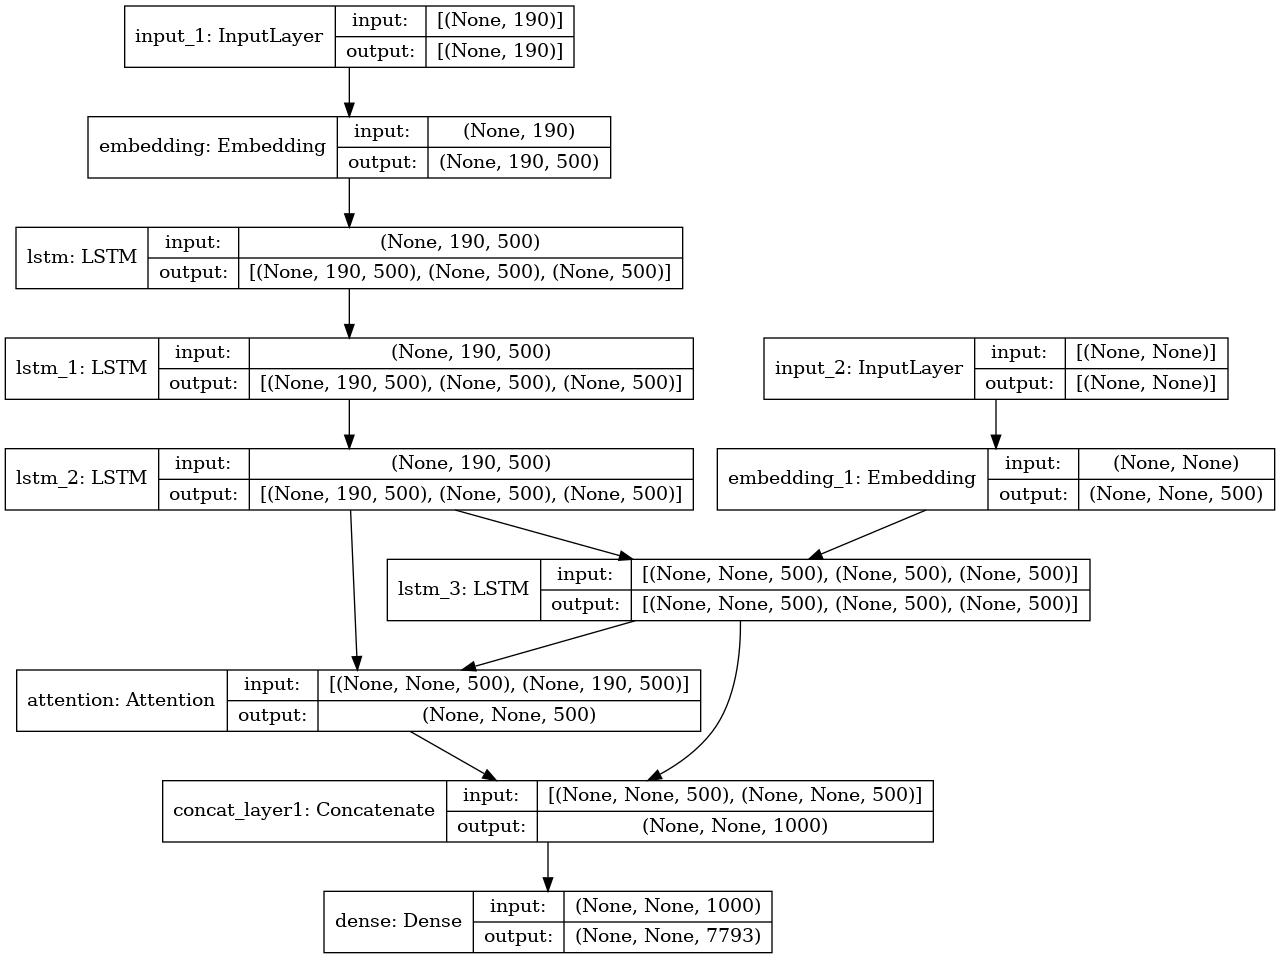

In [165]:
#Model class and model summary for text Summarizer
model = Model([en_inputs, dec_inputs], dec_outputs) 
model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [166]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"] ) 
history = model.fit( 
                    [en_in_data, dec_in_data],
                    dec_tr_data, 
                    batch_size=128, 
                    epochs=50, 
                    validation_split=0.1,)

Epoch 1/50


2022-12-01 20:38:12.624296: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla P100-PCIE-16GB" frequency: 1328 num_cores: 56 environment { key: "architecture" value: "6.0" } environment { key: "cuda" value: "11000" } environment { key: "cudnn" value: "8005" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 16149905408 bandwidth: 732160000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


25/25 [==============================] - ETA: 0s - loss: 1.8025 - accuracy: 0.8247

2022-12-01 20:38:20.932700: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla P100-PCIE-16GB" frequency: 1328 num_cores: 56 environment { key: "architecture" value: "6.0" } environment { key: "cuda" value: "11000" } environment { key: "cudnn" value: "8005" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 16149905408 bandwidth: 732160000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


25/25 [==============================] - 13s 337ms/step - loss: 1.8025 - accuracy: 0.8247 - val_loss: 1.1463 - val_accuracy: 0.8688
Epoch 2/50
25/25 [==============================] - 7s 293ms/step - loss: 1.0860 - accuracy: 0.8675 - val_loss: 1.1322 - val_accuracy: 0.8767
Epoch 3/50
25/25 [==============================] - 7s 294ms/step - loss: 1.0428 - accuracy: 0.8760 - val_loss: 1.1218 - val_accuracy: 0.8765
Epoch 4/50
25/25 [==============================] - 7s 294ms/step - loss: 1.0171 - accuracy: 0.8775 - val_loss: 1.1314 - val_accuracy: 0.8765
Epoch 5/50
25/25 [==============================] - 7s 292ms/step - loss: 0.9972 - accuracy: 0.8776 - val_loss: 1.1341 - val_accuracy: 0.8770
Epoch 6/50
25/25 [==============================] - 7s 292ms/step - loss: 0.9723 - accuracy: 0.8777 - val_loss: 1.1273 - val_accuracy: 0.8769
Epoch 7/50
25/25 [==============================] - 7s 294ms/step - loss: 0.9501 - accuracy: 0.8778 - val_loss: 1.1349 - val_accuracy: 0.8764
Epoch 8/50
25/25

In [167]:
# save model
model.save('Text_Summarizer.h5')
print('Model Saved!')

Model Saved!


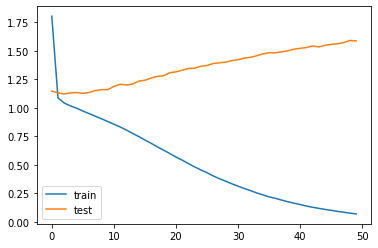

In [168]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [169]:
max_text_len=30
max_summary_len=8

### Next, let’s build the dictionary to convert the index to word for target and source vocabulary:

# Inference Model

### Encoder Inference:

In [170]:
# encoder inference
latent_dim=500
#/content/gdrive/MyDrive/Text Summarizer/
#load the model
model = models.load_model("Text_Summarizer.h5")
 
#construct encoder model from the output of 6 layer i.e.last LSTM layer
en_outputs,state_h_enc,state_c_enc = model.layers[6].output
en_states=[state_h_enc,state_c_enc]
#add input and state from the layer.
en_model = Model(model.input[0],[en_outputs]+en_states)

### Decoder Inference:

In [171]:
# decoder inference
#create Input object for hidden and cell state for decoder
#shape of layer with hidden or latent dimension
dec_state_input_h = Input(shape=(latent_dim,))
dec_state_input_c = Input(shape=(latent_dim,))
dec_hidden_state_input = Input(shape=(max_in_len,latent_dim))
 
# Get the embeddings and input layer from the model
dec_inputs = model.input[1]
dec_emb_layer = model.layers[5]
dec_lstm = model.layers[7]
dec_embedding= dec_emb_layer(dec_inputs)
 
#add input and initialize LSTM layer with encoder LSTM states.
dec_outputs2, state_h2, state_c2 = dec_lstm(dec_embedding, initial_state=[dec_state_input_h,dec_state_input_c])

### Attention Inference:

In [172]:
#Attention layer
attention = model.layers[8]
attn_out2 = attention([dec_outputs2,dec_hidden_state_input])
 
merge2 = Concatenate(axis=-1)([dec_outputs2, attn_out2])

### Dense layer

In [173]:
#Dense layer
dec_dense = model.layers[10]
dec_outputs2 = dec_dense(merge2)
 
# Finally define the Model Class
dec_model = Model(
[dec_inputs] + [dec_hidden_state_input,dec_state_input_h,dec_state_input_c],
[dec_outputs2] + [state_h2, state_c2])

In [174]:
#create a dictionary with a key as index and value as words.
reverse_target_word_index = tr_tokenizer.index_word
reverse_source_word_index = in_tokenizer.index_word
target_word_index = tr_tokenizer.word_index

In [175]:
def decode_sequence(input_seq):
    # get the encoder output and states by passing the input sequence
    en_out, en_h, en_c = en_model.predict(input_seq)

    # target sequence with inital word as 'sos'
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = target_word_index['sos']

    # if the iteration reaches the end of text than it will be stop the iteration
    stop_condition = False
    # append every predicted word in decoded sentence
    decoded_sentence = ""
    while not stop_condition:
        # get predicted output, hidden and cell state.
        output_words, dec_h, dec_c = dec_model.predict([target_seq] + [en_out, en_h, en_c])

        # get the index and from the dictionary get the word for that index.
        word_index = np.argmax(output_words[0, -1, :])
        #if(word_index!=0):
        text_word = reverse_target_word_index[word_index]
        decoded_sentence += text_word + " "

        # Exit condition: either hit max length
        # or find a stop word or last word.
        if text_word == "eos" or len(decoded_sentence) > max_tr_len:
                stop_condition = True

        # update target sequence to the current word index.
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = word_index
        en_h, en_c = dec_h, dec_c

    # return the deocded sentence
    return decoded_sentence

In [176]:
# inp_review = input("Enter : ")
inp_review = "The Administration of Union Territory Daman and Diu has revoked its order that made it compulsory for women to tie rakhis to their male colleagues on the occasion of Rakshabandhan on August 7. The administration was forced to withdraw the decision within 24 hours of issuing the circular after it received flak from employees and was slammed on social media."
print("Review :", inp_review)

inp_review = clean(inp_review, "inputs")
inp_review = ' '.join(inp_review)
inp_x = in_tokenizer.texts_to_sequences([inp_review])
inp_x = pad_sequences(inp_x, maxlen=max_in_len, padding='post')

summary = decode_sequence(inp_x.reshape(1, max_in_len))
if 'eos' in summary:
    summary = summary.replace('eos', '')
print("\nPredicted summary:", summary);
print("\n")

Review : The Administration of Union Territory Daman and Diu has revoked its order that made it compulsory for women to tie rakhis to their male colleagues on the occasion of Rakshabandhan on August 7. The administration was forced to withdraw the decision within 24 hours of issuing the circular after it received flak from employees and was slammed on social media.


2022-12-01 20:44:38.325217: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla P100-PCIE-16GB" frequency: 1328 num_cores: 56 environment { key: "architecture" value: "6.0" } environment { key: "cuda" value: "11000" } environment { key: "cudnn" value: "8005" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 16149905408 bandwidth: 732160000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }



Predicted summary: daman diu revokes mandatory rakshabandhan offices order 




In [177]:
from sklearn.metrics.pairwise import cosine_similarity

In [178]:
d = {"text": [], "actual": [], "predict": [], "similarity": []}

In [179]:
from sklearn.feature_extraction.text import CountVectorizer
def COSINE(base_document,document):
    content = [base_document, document]
    cv = CountVectorizer()
    count_matrix = cv.fit_transform(content)

    from sklearn.metrics.pairwise import cosine_similarity
    mat = cosine_similarity(count_matrix)
    return mat[1][0]*100

In [180]:
for i in range(0,15):
    # inp_review = input("Enter : ")
    inp_review = X_test[i]
    print("Review :", inp_review)
    d['text'].append(X_test[i])
    d['actual'].append(Y_test[i])
    inp_review = clean(inp_review, "inputs")
    inp_review = ' '.join(inp_review)
    inp_x = in_tokenizer.texts_to_sequences([inp_review])
    inp_x = pad_sequences(inp_x, maxlen=max_in_len, padding='post')
    summary = decode_sequence(inp_x.reshape(1, max_in_len))
    if 'eos' in summary:
        summary = summary.replace('eos', '')
    print("\nPredicted summary:", summary);
    d['predict'].append(summary)
    d['similarity'].append(COSINE(Y_test[i],summary))
    print("\n")
    

Review : actress sonaksh sinh react report get marry rumo boyfriend bunty sajdeh said let peopl talk log toh kaheng logon kaam hai kehn ad ev know typ guy would lik get marry rumo coupl rec spot togeth screening anushk sharm star

Predicted summary: priyanka slammed alleged lip job instagram picture  


Review : ahead first phas pol held febru jam masjid shah imam syed ahm bukhar urg muslim commun support bsp met mulayam sev tim issu reserv muslim netaj brought not akhilesh yadav noth said

Predicted summary: stuck bans school next take stuck middle runway  


Review : least six peopl kil fir struck electron good fact noid sect wednesday afternoon fact employ claim fir tend reach spot minut complaint reg good estim wor around cror destroy fir caus short circuit

Predicted summary: fire electronics factory noida kills six  


Review : transit biomet attend brihanmumba municip corp bmc annount employ receiv sal fail mark attend system almost bmc lakh employ already reg new system report 

In [181]:
new = pd.DataFrame.from_dict(d)

In [182]:
new

,text,actual,predict,similarity
0,actress sonaksh sinh react report get marry rumo boyfriend bunty sajdeh said let peopl talk log toh kaheng logon kaam hai kehn ad ev know typ guy would lik get marry rumo coupl rec spot togeth scr...,sos logon kaam hai kehna sonakshi sinha marriage rumours eos,priyanka slammed alleged lip job instagram picture,0.000000
1,ahead first phas pol held febru jam masjid shah imam syed ahm bukhar urg muslim commun support bsp met mulayam sev tim issu reserv muslim netaj brought not akhilesh yadav noth said,sos jama masjid shahi imam urges muslims support bsp eos,stuck bans school next take stuck middle runway,0.000000
2,least six peopl kil fir struck electron good fact noid sect wednesday afternoon fact employ claim fir tend reach spot minut complaint reg good estim wor around cror destroy fir caus short circuit,sos fire electronics factory noida kills six eos,fire electronics factory noida kills six,86.602540
3,transit biomet attend brihanmumba municip corp bmc annount employ receiv sal fail mark attend system almost bmc lakh employ already reg new system report said com part revamp also includ chang off...,sos biometric attendance means salary bmc employees eos,biometric attendance means salary bmc employees,86.602540
4,complet delh metro phas clear rec govern lik mak metro system largest outsid chin report said delh metro cur largest estim carry lakh peopl regul complet phas ad delh metro network,sos delhi metro may become largest metro system outside china eos,delhi metro may become largest metro system outside china,91.986621
5,two lead yuv sen tuesday ask brihanmumba municip corp commit fil cror defam cas red host malishk controversy ensu vir song channel alleg mad fun bmc claim channel defam corp problem outsid jurisdict,sos yuva sena leaders ask bmc file case malishka eos,yuva sena leaders ask bmc file case malishka,89.442719
6,twinkl khann rev son aarav friend cal believ comply today tim ad sound aw believ good thing son say least twinkl said tri friend moth kid,sos son aarav friends call savage twinkle khanna eos,kamal haasan day panel alphonse,0.000000
7,ind air forc induc country first indig airborn ear warn control aew system also cal sky febru first day aero ind system cap detect incom fight cru missil ev dron pak chin accord report,sos iaf induct first indigenously developed sky eos,iaf induct first indigenously developed sky,86.602540
8,presid donald trump report enco nat bid joint host footbal world cup along canad mexico bid process expect begin lat year expect fin sixty match would host mexico canad would host,sos trump backs usa joint bid canada mexico eos,trump backs usa joint bid canada mexico,88.191710
9,donald trump said britain exit europ un going end gre thing look europ un germany bas vehic germany thought smart get stat trump said expect country leav wel,sos brexit going great thing says trump eos,brexit going great thing says trump,86.602540


In [183]:
print("Accuracy:",sum(d['similarity'])/len(d['similarity']))

Accuracy: 60.4432418969195
